# Laplace Out of the Money Price Simulation

In [5]:

import math
import random as random

import pandas as pd

import numpy as np
from numpy.random import default_rng
np.set_printoptions(precision=5, suppress=True)

# fixes the seed for reproducibility
rng = default_rng(99)

import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy as scipy
from scipy.optimize import fsolve

import psycopg2

# import seaborn as sns

from math import log, sqrt, exp, pi
from scipy.stats import norm, laplace, t as student_t

# Markdown in code cell
from IPython.display import Markdown as md


plt.style.use('seaborn')
plt.colormaps
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'


# Fee calculator
def bsm_no_premium_call_option_fee(S0, T, sigma):
    # BSM no-premium option strike calculator
    def bsm_no_premium_strike(S0, T, sigma):
        # init
        r = 0.0
        K_at_money = S0
        # bsm terms
        d1 = (log(S0/K_at_money) + (r + 0.5 * sigma**2) * T) / sigma / sqrt(T)
        d2 = d1 - sigma * sqrt(T)
        N_d1 = norm.cdf(d1)
        N_d2 = norm.cdf(d2)
        
        def bsm_premium(K):
            # bsm premium
            BSM_C0_no_premium = S0 * N_d1 - K * exp(-r*T) * N_d2
            return BSM_C0_no_premium
        
        K_no_premium = fsolve(bsm_premium, K_at_money)[0]
        
        return K_no_premium

    K_no_premium = bsm_no_premium_strike(S0, T, sigma)

    fee = (K_no_premium-S0)/S0

    return fee

def mc_no_premium_call_option_fee(S0, T, sigma, I):
    # MC no-premium option strike calculator
    def mc_no_premium_strike(S0, T, sigma, I):
        # init
        r = 0.0
        K_at_money = S0

        # underlying price vector at maturity
        mc_rng = default_rng()
        ST = S0 * np.exp((r - sigma ** 2 / 2) * T + sigma * math.sqrt(T) * mc_rng.standard_normal(I))

        def mc_premium(K):
            # not exercised
            CT_below_K_at_money = ST[ST <= K_at_money] * 0

            # exercised at a loss
            CT_below_K = ST[ST > K_at_money]
            CT_below_K = CT_below_K[CT_below_K <= K] - K

            # exercised at a gain
            CT_above_K = ST[ST > K] - K

            # call option payoff at maturity
            CT_no_premium = np.concatenate((CT_below_K_at_money, CT_below_K, CT_above_K))

            CT_no_premium_mean = CT_no_premium.mean()

            # call option fair value
            MC_C0_no_premium = math.exp(-r * T) * CT_no_premium_mean

            return MC_C0_no_premium
        
        K_no_premium = fsolve(mc_premium, K_at_money)[0]
        
        return K_no_premium

    K_no_premium = mc_no_premium_strike(S0, T, sigma, I)

    fee = (K_no_premium-S0)/S0

    return fee

# Data set
btcusd_1min = pd.read_csv("./BTCUSD.csv", sep=",", header=0, names=["date","open","high","low","close"], index_col="date")

btcusd_1min['ret_2min'] = np.log(btcusd_1min['close'] / btcusd_1min['close'].shift(2))

# Using the most recent 30 days worth of data only
nb_2min_in_30d = 30*24*30 # = 21600
ret_2min = btcusd_1min['ret_2min'][-21600:]
# ret_2min = btcusd_1min['ret_2min'][2:]

# the 2-min vol
vol_2min = ret_2min.std()

# number of 2-minute per year
nb_2min_per_year = 60/2 * 24 * 365.25
vol_ann = vol_2min * sqrt(nb_2min_per_year)


## Monte Carlo Simulation

It has already been established in [Log Normal At the Money Price Simulation](normal_at_money_simulation.ipynb) and [Log Normal Out of the Money Price Simulation](normal_out_money_simulation.ipynb) that a Monte Carlo simulation with normally distributed samples estimates the same option premium as the Black–Scholes–Merton analytical formula.

It is also apparent from [Historical Returns Distribution fitting](historical_returns_fit.ipynb) that the BTC/USD returns are not normally distributed and that a Laplace distribution might be more representative of the observed fat tails.

A Monte Carlo simulation using Laplace samples will be implemented to compare the impact on the "no-premium" option's stike.



In [22]:

# underlying price at t=0
S0 = 30_000.00

# risk free rate (no present value discounting)
r = 0.0

# 2min yearly fraction
T = 1 / (60/2 * 24 * 365.25)

# annualized 2min volatility
sigma = vol_ann

# number of price simulations
I = 1_000_000

# sample size
N = nb_2min_in_30d

# # calc bsm fee
# bsm_fee = bsm_no_premium_call_option_fee(S0, T, sigma)

# # calc mc fee
# mc_fee = mc_no_premium_call_option_fee(S0, T, sigma, I)

header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|S(0)|{float('%.8g' % S0)} USD|\n"
table += f"|T|{float('%.3g' % T)}|\n"
table += f"|r|{r}|\n"
table += f"|σ|{float('%.5g' % (sigma*100))}%|\n"
table += f"|I|{I}|\n"

table2 = ""
table2 += f"|Samples| most recent 30 days|\n"
table2 += f"|N|{N}|\n"

md(f"""### Simulation variables
{header}
{table}
### Calculated Fees
{header}
{table2}
""")


### Simulation variables
|variable|value|
|:-:|-:|
|S(0)|30000.0 USD|
|T|3.8e-06|
|r|0.0|
|σ|107.01%|
|I|1000000|

### Calculated Fees
|variable|value|
|:-:|-:|
|Samples| most recent 30 days|
|N|21600|



In [7]:

mean = ret_2min.mean()
std = ret_2min.std()

# Fit the Normal PDF.
m,s = norm.fit(ret_2min)

# Fit the Laplace PDF.
loc,scale = laplace.fit(ret_2min)

# Fit the Student's t PDF.
df, tloc, tscale = student_t.fit(ret_2min)

header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|Normal mean|{float('%.5g' % mean)}|\n"
table += f"|Normal std|{float('%.5g' % std)}|\n"
table += f"|Normal std/sqrt(2)|{float('%.5g' % (std/sqrt(2)))}|\n"
# table += f"|Laplace scale*sqrt(2)|{float('%.5g' % (scale*sqrt(2)))}|\n"
table += f"|Laplace scale|{float('%.5g' % scale)}|\n"
table += f"|Laplace location|{float('%.5g' % loc)}|\n"

md(f"""### Data fitting stats
{header}
{table}
""")


### Data fitting stats
|variable|value|
|:-:|-:|
|Normal mean|2.7208e-06|
|Normal std|0.0020866|
|Normal std/sqrt(2)|0.0014755|
|Laplace scale|0.0012904|
|Laplace location|-2.0079e-05|



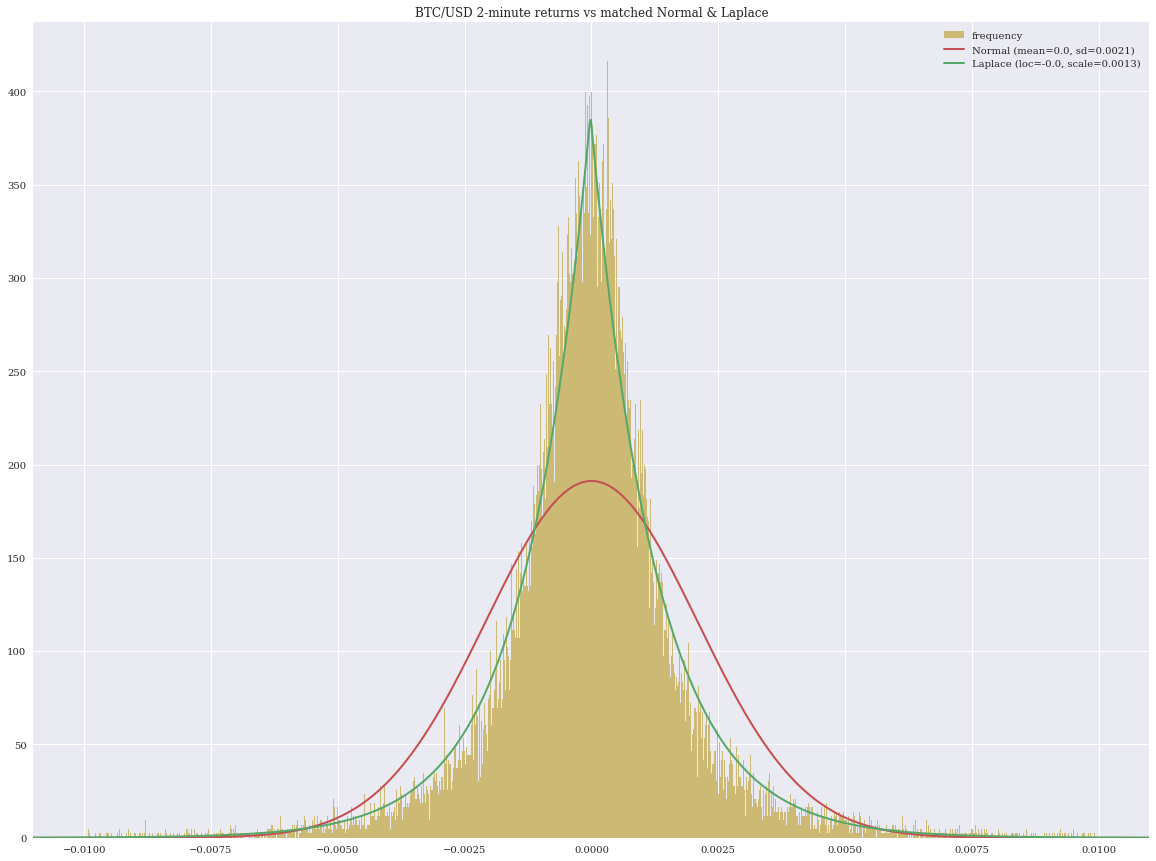

In [8]:

mean = ret_2min.mean()
std = ret_2min.std()

plt.figure(figsize=(20, 15))
plt.title("BTC/USD 2-minute returns vs matched Normal & Laplace")
plt.hist(ret_2min, color='C4', bins=1000, label='frequency', align='mid', density=True, range=[-0.01,0.01]);

#  Plot the Normal PDF.
# m,s = norm.fit(ret_2min)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, m, s)
ST_norm = S0 * np.exp(norm.rvs(m, s, size=I, random_state=99))
plt.plot(x, p, color='C2', linewidth=2, scalex=False, scaley=False, label=f"Normal (mean={m.round(4)}, sd={s.round(4)})")

#  Plot the Laplace PDF.
# loc,scale = laplace.fit(ret_2min)
l = laplace.pdf(x, loc, scale)
ST_laplace = S0 * np.exp(laplace.rvs(loc, scale, size=I, random_state=99))
plt.plot(x, l, color='C1', linewidth=2, scalex=False, scaley=False, label=f"Laplace (loc={loc.round(4)}, scale={scale.round(4)})")

# #  Plot the student-t PDF.
# df, tloc, tscale = student_t.fit(ret_2min)
# t = student_t.pdf(x, df, tloc, tscale)
# plt.plot(x, t, color='C3', linewidth=2, scalex=False, scaley=False, label=f"Student's t (df={df.round(2)}, tloc={tloc.round(4)}, tscale={tscale.round(4)})")

plt.legend(loc="best");
plt.show()

In [9]:

# underlying price vector from laplace 2-minute log-returns
ST = S0 * np.exp(laplace.rvs(loc, scale, size=I, random_state=99))

# # underlying price vector from bootstrapped 2-minute log-returns
# some for loop over choice of returns from sample giving one avg return & loop for a new sample of avg of return from samples ;)
# ret_2min_boot = random.choices(ret_2min, k=ret_2min.size)
# ST_boot = S0 * np.exp(ret_2min_boot)


header = '''|variable|value|
|:-:|-:|'''

table2 = ""
table2 += f"|S(T)|{ST[:5].round(1)}...|\n"

md(f"""### Terminal prices samples
{header}
{table2}
""")


### Terminal prices samples
|variable|value|
|:-:|-:|
|S(T)|[30015.8 29998.5 30040.2 29892.5 30036.5]...|



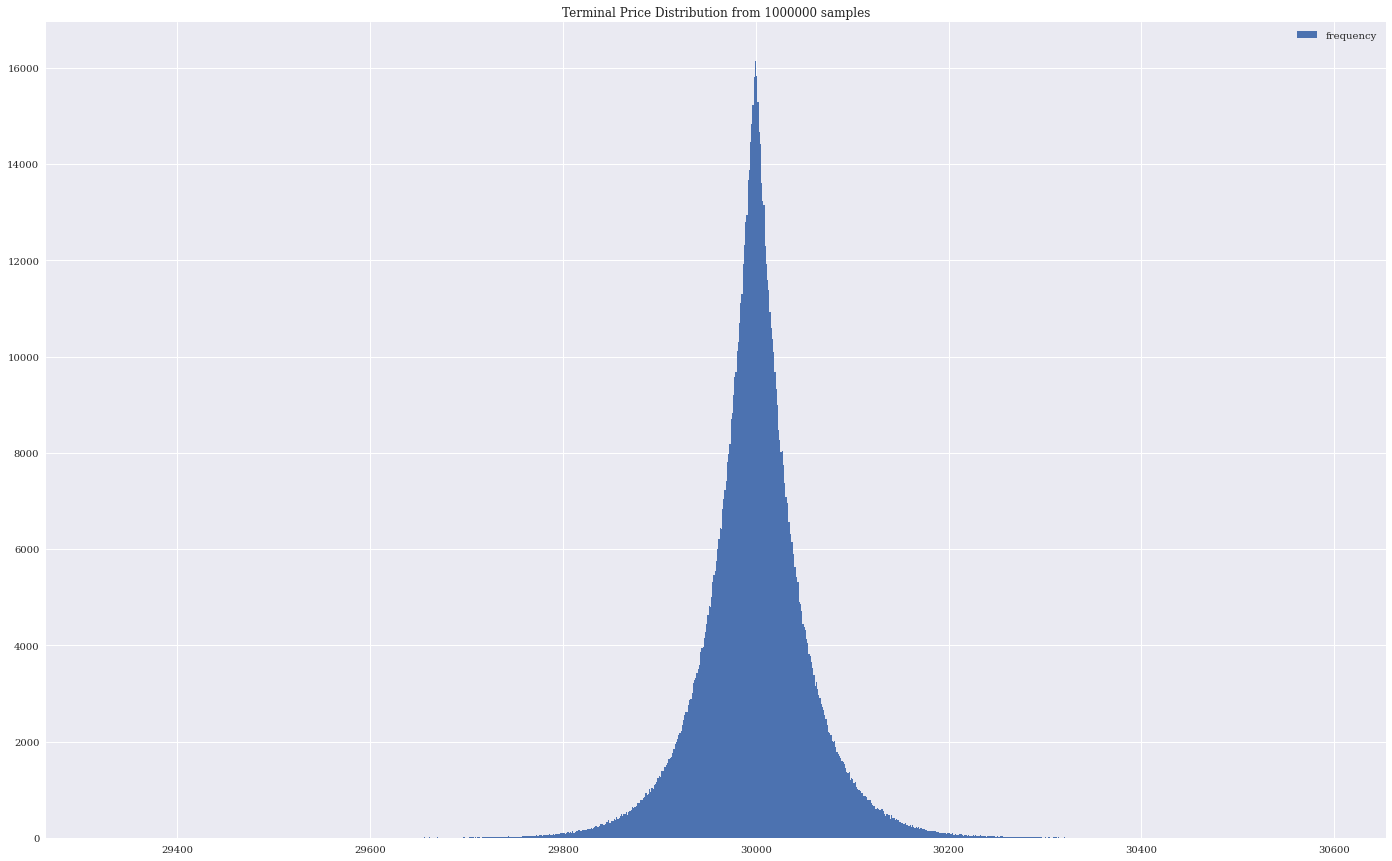

In [10]:

plt.figure(figsize=(24, 15))
plt.hist(ST, bins=1000, label='frequency');

plt.title(f'Terminal Price Distribution from {I} samples')
plt.legend(loc='best');
plt.show()

## Present Value of the expected payoff

In [11]:

# at-the-money strike price => fair value @ 50%-50% exercise probability
K_at_money = S0

# call option payoff at maturity
CT_at_money = np.maximum(ST - K_at_money, 0)

# out-of-the-money strike price => 
# add once the premium of the at-the-money option to the strike price as an experiment
K = S0 + CT_at_money.mean()

# call option payoff at maturity
CT = np.maximum(ST - K, 0)

CT_mean = CT.mean()
CT_std = CT.std()

# call option fair value
C0 = math.exp(-r * T) * CT_mean

header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|K|{float('%.8g' % K)} USD|\n"

table2 = ""
table2 += f"|C(T)|{CT[:5].round(1)}...|\n"

table3 = ""
table3 += f"|C(T) mean|{float('%.4g' % CT_mean)}|\n"
table3 += f"|C(T) std|{float('%.4g' % CT_std)}|\n"
table3 += f"|C0|{float('%.4g' % C0)}|\n"

md(f"""### Option payoff variables
{header}
{table}
### Terminal option payoff samples
{header}
{table2}
### Terminal option payoff stats
{header}
{table3}""")


### Option payoff variables
|variable|value|
|:-:|-:|
|K|30019.043 USD|

### Terminal option payoff samples
|variable|value|
|:-:|-:|
|C(T)|[ 0.   0.  21.1  0.  17.4]...|

### Terminal option payoff stats
|variable|value|
|:-:|-:|
|C(T) mean|11.64|
|C(T) std|27.69|
|C0|11.64|


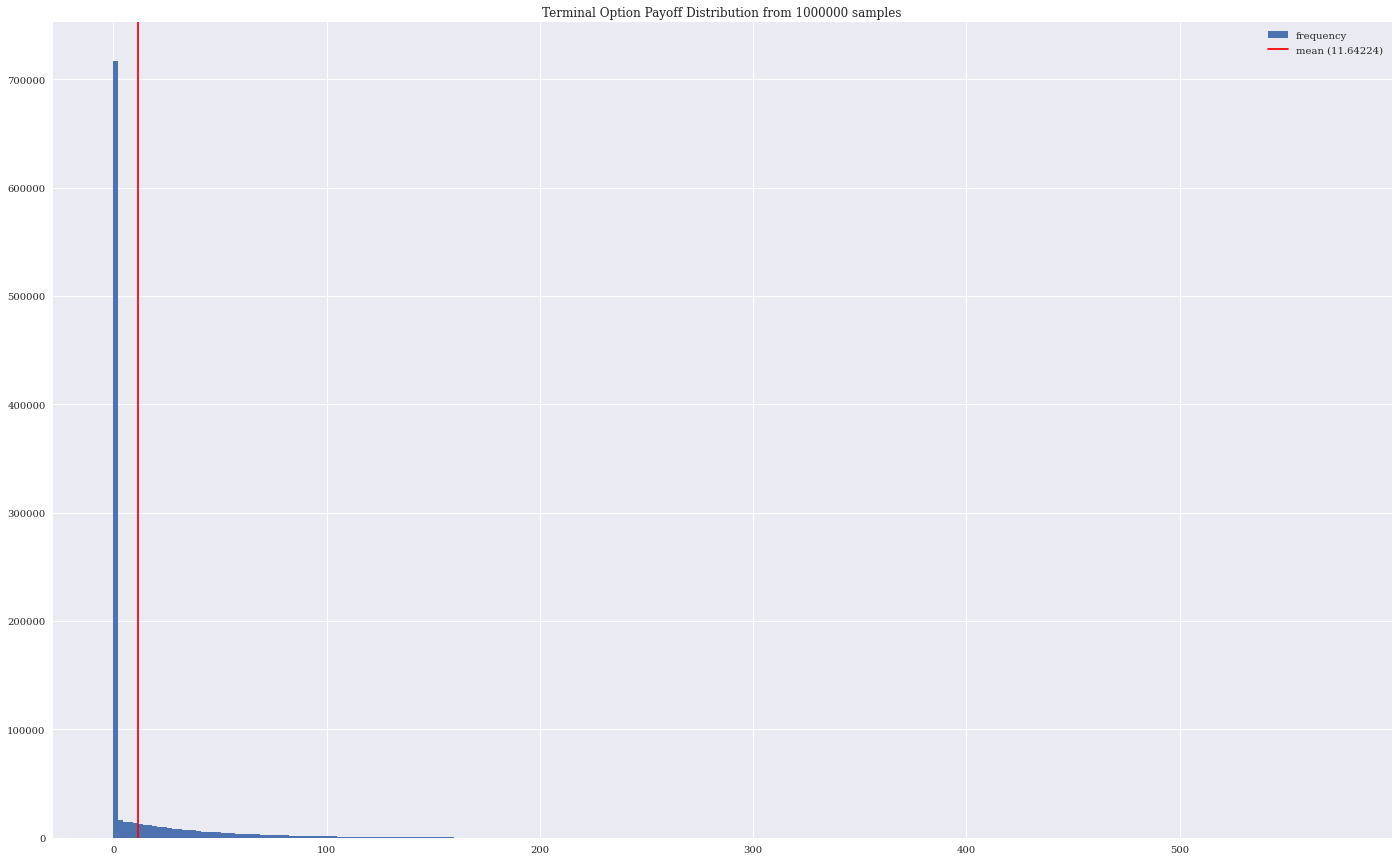

In [12]:

plt.figure(figsize=(24, 15))
plt.hist(CT, bins=250, label='frequency');

plt.axvline(CT_mean, color='r', label=f"mean ({float('%.7g' % (CT_mean))})")

plt.title(f'Terminal Option Payoff Distribution from {I} samples')
plt.legend(loc='best');
plt.show()

## Identifying option payoff terms in terminal price distribution



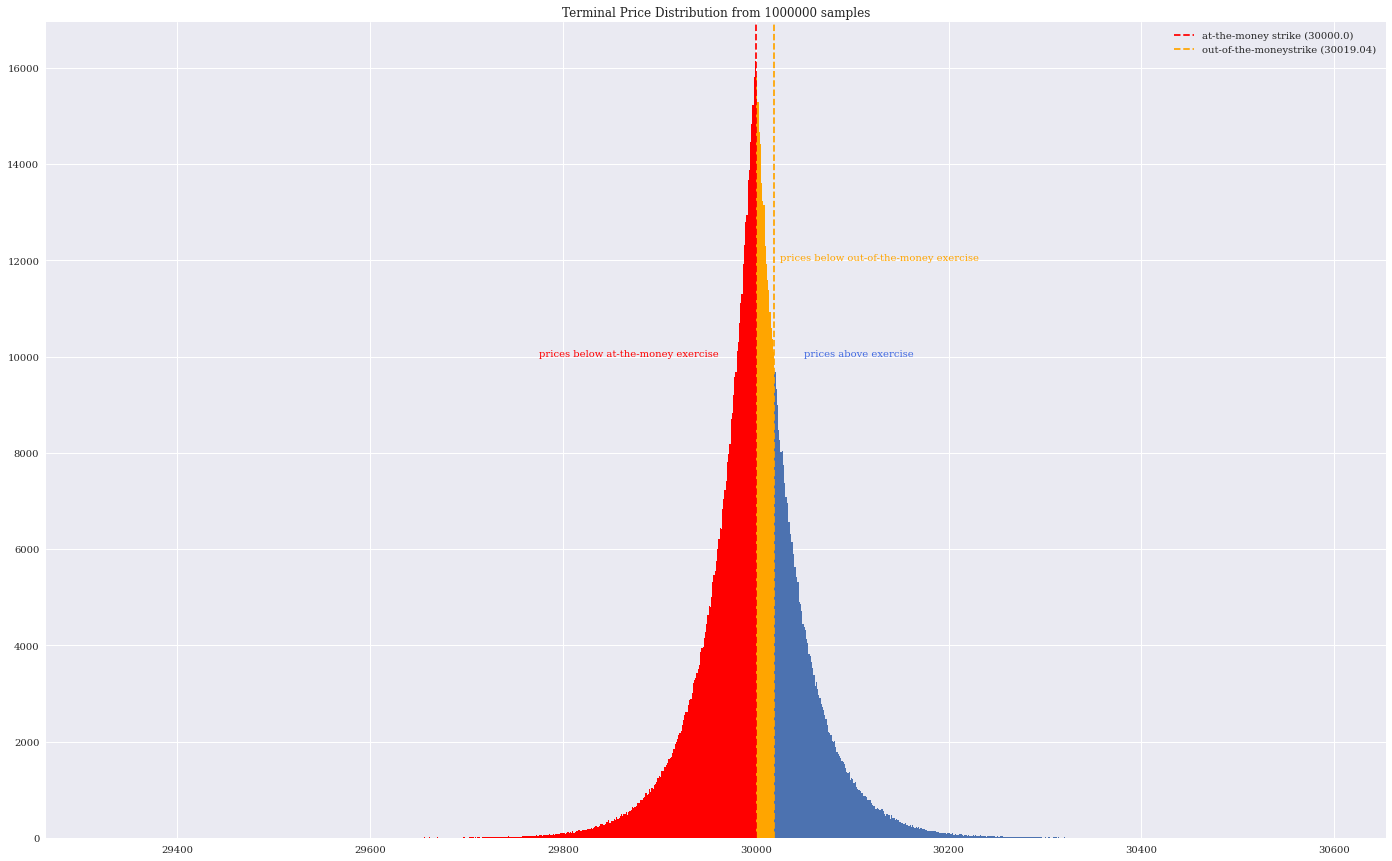

In [13]:

plt.figure(figsize=(24, 15))
n, bins, patches = plt.hist(ST, bins=1000);
for c, p in zip(bins, patches):
    if c <= K_at_money:
        plt.setp(p, 'facecolor', 'red')
    elif c > K_at_money and c <= K:
        plt.setp(p, 'facecolor', 'orange')
    # else:
    #     plt.setp(p, 'facecolor', 'royalblue')

plt.axvline(K_at_money, color='r', label=f"at-the-money strike ({float('%.7g' % (K_at_money))})", linestyle='--')
plt.axvline(K, color='orange', label=f"out-of-the-moneystrike ({float('%.7g' % (K))})", linestyle='--')

plt.text(29775, 10000, "prices below at-the-money exercise", color='r')
plt.text(30025, 12000, "prices below out-of-the-money exercise", color='orange')
plt.text(30050, 10000, "prices above exercise", color='royalblue')

plt.title(f'Terminal Price Distribution from {I} samples')
plt.legend(loc='best');
plt.show()


In [14]:

ST_below_K = ST[ST <= K]
ST_above_K = ST[ST > K]

ST_N_d1 = np.concatenate((ST_below_K*0, ST_above_K))


header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|Count(ST <= K)|{ST_below_K.size}|\n"
table += f"|Count(ST  > K)|{ST_above_K.size}|\n"
table += f"|Total Count|{ST_below_K.size + ST_above_K.size}|\n"
table += f"|Nbr of sims (I)|{I}|\n"
table += f"|Percent(ST <= K)|{float('%.4g' % (ST_below_K.size/I))}|\n"
table += f"|Percent(ST  > K)|{float('%.4g' % (ST_above_K.size/I))}|\n"

md(f"""### Frequency stats
{header}
{table}
""")


### Frequency stats
|variable|value|
|:-:|-:|
|Count(ST <= K)|699334|
|Count(ST  > K)|300666|
|Total Count|1000000|
|Nbr of sims (I)|1000000|
|Percent(ST <= K)|0.6993|
|Percent(ST  > K)|0.3007|



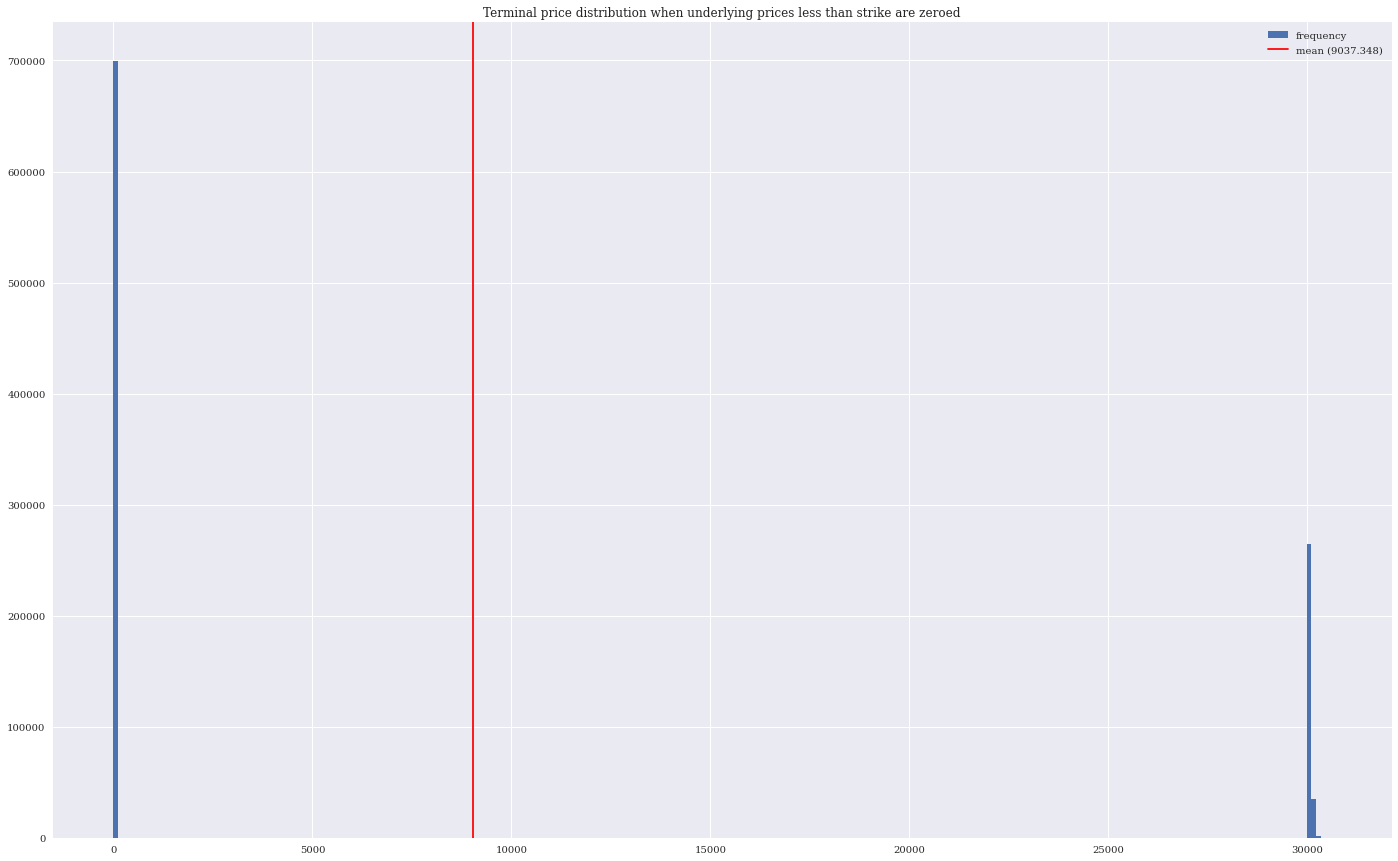

In [15]:

plt.figure(figsize=(24, 15))
plt.hist(ST_N_d1, bins=250, label='frequency');

plt.axvline(ST_N_d1.mean(), color='r', label=f"mean ({float('%.7g' % (ST_N_d1.mean()))})")

plt.title(f'Terminal price distribution when underlying prices less than strike are zeroed')
plt.legend(loc='best');
plt.show()

## No-premium Option Payoff

In [16]:

# not exercised
CT_below_K_at_money = ST[ST <= K_at_money] * 0

# exercised at a loss
CT_below_K = ST[ST > K_at_money]
CT_below_K = CT_below_K[CT_below_K <= K] - K

# exercised at a gain
CT_above_K = ST[ST > K] - K

# call option payoff at maturity
CT_no_premium = ST_N_d1 = np.concatenate((CT_below_K_at_money, CT_below_K, CT_above_K))

CT_no_premium_mean = CT_no_premium.mean()
CT_no_premium_std = CT_no_premium.std()

# call option fair value
C0_no_premium = math.exp(-r * T) * CT_no_premium_mean

header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|K|{float('%.8g' % K)} USD|\n"
table += f"|K_at_money|{float('%.8g' % K_at_money)} USD|\n"

table2 = ""
table2 += f"|C_no_premium(T)|{CT_no_premium[-5:].round(1)}...|\n"
table2 += f"|Count(C_no_premium(T))|{CT_no_premium.size}|\n"

table3 = ""
table3 += f"|C_no_premium(T) mean|{float('%.4g' % CT_no_premium_mean)}|\n"
table3 += f"|C_no_premium(T) std|{float('%.4g' % CT_no_premium_std)}|\n"
table3 += f"|C0_no_premium|{float('%.4g' % C0_no_premium)}|\n"

md(f"""### Option payoff variables
{header}
{table}
### Terminal option payoff samples
{header}
{table2}
### Terminal option payoff stats
{header}
{table3}""")


### Option payoff variables
|variable|value|
|:-:|-:|
|K|30019.043 USD|
|K_at_money|30000.0 USD|

### Terminal option payoff samples
|variable|value|
|:-:|-:|
|C_no_premium(T)|[ 1.4 24.8  2.2 50.1 56. ]...|
|Count(C_no_premium(T))|1000000|

### Terminal option payoff stats
|variable|value|
|:-:|-:|
|C_no_premium(T) mean|9.668|
|C_no_premium(T) std|28.89|
|C0_no_premium|9.668|


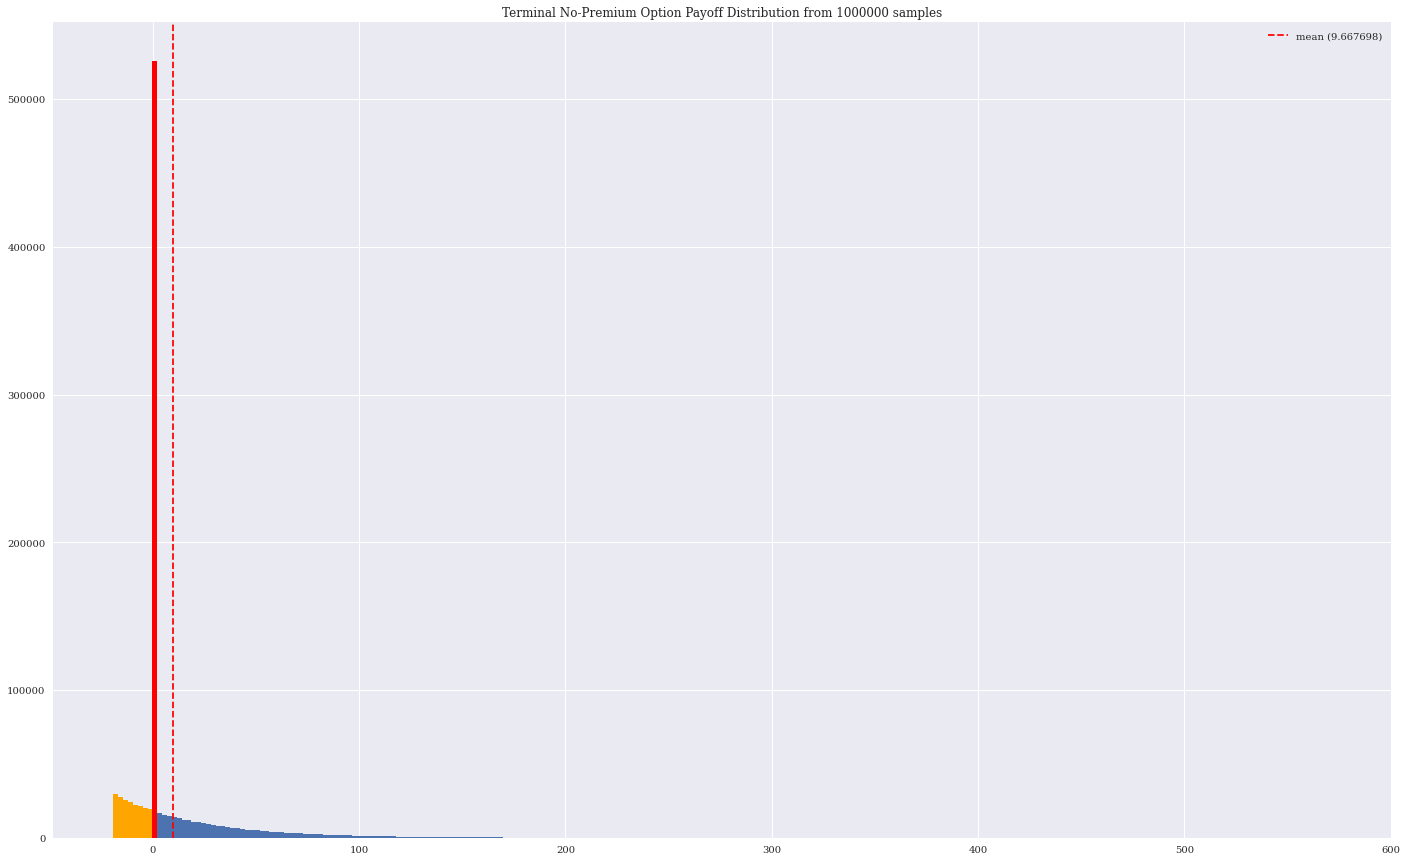

In [17]:

plt.figure(figsize=(24, 15))
n, bins, patches = plt.hist(CT_no_premium, bins=250);
mode_index = n.argmax()
for c, p in zip(bins, patches):
    if c >= bins[mode_index] and c < bins[mode_index+1]:
        plt.setp(p, 'facecolor', 'red')
    elif c < 0:
        plt.setp(p, 'facecolor', 'orange')
    # else:
    #     plt.setp(p, 'facecolor', 'royalblue')

plt.axvline(CT_no_premium_mean, color='r', label=f"mean ({float('%.7g' % (CT_no_premium_mean))})", linestyle='--')

plt.title(f'Terminal No-Premium Option Payoff Distribution from {I} samples')
plt.legend(loc='best');
plt.show()


In [18]:

# not exercised
ST_below_K_at_money = ST[ST <= K_at_money]

# exercised at a loss
ST_below_K = ST[ST > K_at_money]
ST_below_K = ST_below_K[ST_below_K <= K]
 
# exercised at a gain
ST_above_K = ST[ST > K]


ST_N_d1 = np.concatenate((ST_below_K_at_money*0, ST_below_K, ST_above_K))


header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|Count(ST <= K_at_money)|{ST_below_K_at_money.size}|\n"
table += f"|Count(ST <= K)|{ST_below_K.size}|\n"
table += f"|Count(ST  > K)|{ST_above_K.size}|\n"
table += f"|Total Count|{ST_below_K_at_money.size + ST_below_K.size + ST_above_K.size}|\n"
table += f"|Nbr of sims (I)|{I}|\n"
table += f"|Percent(ST <= K)|{float('%.4g' % (ST_below_K_at_money.size/I))}|\n"
table += f"|Percent(ST  > K)|{float('%.4g' % ((ST_below_K.size + ST_above_K.size)/I))}|\n"

md(f"""### Frequency stats
{header}
{table}
""")


### Frequency stats
|variable|value|
|:-:|-:|
|Count(ST <= K_at_money)|507669|
|Count(ST <= K)|191665|
|Count(ST  > K)|300666|
|Total Count|1000000|
|Nbr of sims (I)|1000000|
|Percent(ST <= K)|0.5077|
|Percent(ST  > K)|0.4923|



## Solving for the No-premium option strike

In [19]:
# MC Laplace no-premium option strike calculator

def mc_laplace_premium(S0, K, T, loc, scale, I):
    # init
    r = 0.0
    K_at_money = S0

    # underlying price vector at maturity
    mc_rng = default_rng()
    ST = S0 * np.exp(laplace.rvs(loc, scale, size=I, random_state=99))
    # not exercised
    CT_below_K_at_money = ST[ST <= K_at_money] * 0

    # exercised at a loss
    CT_below_K = ST[ST > K_at_money]
    CT_below_K = CT_below_K[CT_below_K <= K] - K

    # exercised at a gain
    CT_above_K = ST[ST > K] - K

    # call option payoff at maturity
    CT_no_premium = np.concatenate((CT_below_K_at_money, CT_below_K, CT_above_K))

    CT_no_premium_mean = CT_no_premium.mean()

    # call option fair value
    MC_C0_no_premium = math.exp(-r * T) * CT_no_premium_mean

    return MC_C0_no_premium

def mc_laplace_no_premium_strike(S0, T, loc, scale, I):
    # init
    r = 0.0
    K_at_money = S0

    # underlying price vector at maturity
    mc_rng = default_rng()
    ST = S0 * np.exp(laplace.rvs(loc, scale, size=I, random_state=99))

    def mc_premium(K):
        # not exercised
        CT_below_K_at_money = ST[ST <= K_at_money] * 0

        # exercised at a loss
        CT_below_K = ST[ST > K_at_money]
        CT_below_K = CT_below_K[CT_below_K <= K] - K

        # exercised at a gain
        CT_above_K = ST[ST > K] - K

        # call option payoff at maturity
        CT_no_premium = np.concatenate((CT_below_K_at_money, CT_below_K, CT_above_K))

        CT_no_premium_mean = CT_no_premium.mean()

        # call option fair value
        MC_C0_no_premium = math.exp(-r * T) * CT_no_premium_mean

        return MC_C0_no_premium
    
    K_no_premium = fsolve(mc_premium, K_at_money)[0]
    
    return K_no_premium


K_laplace_no_premium = mc_laplace_no_premium_strike(S0, T, loc, scale, I)
# k_laplace = mc_laplace_premium(S0, K_no_premium, T, l_loc, l_scale, I)

K_laplace_no_premium

30038.679892744392

In [21]:

# calc bsm fee
bsm_fee = bsm_no_premium_call_option_fee(S0, T, sigma)

# calc mc fee
mc_fee = mc_no_premium_call_option_fee(S0, T, sigma, I)

header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|S(0)|{float('%.8g' % S0)} USD|\n"
table += f"|T|{float('%.3g' % T)}|\n"
table += f"|r|{r}|\n"
table += f"|σ|{float('%.5g' % (sigma*100))}%|\n"
table += f"|Laplace loc|{float('%.5g' % loc)}|\n"
table += f"|Laplace scale|{float('%.5g' % scale)}|\n"
table += f"|I|{I}|\n"

table2 = ""
table2 += f"|BSM strike|{float('%.5g' % ((1+bsm_fee)*S0))} USD|\n"
table2 += f"|MC Normal strike|{float('%.5g' % ((1+mc_fee)*S0))} USD|\n"
table2 += f"|MC Laplace strike|{float('%.5g' % (K_laplace_no_premium))} USD|\n"

table3 = ""
table3 += f"|BSM fee|{float('%.5g' % (bsm_fee*100))}%|\n"
table3 += f"|MC Normal fee|{float('%.5g' % (mc_fee*100))}%|\n"
table3 += f"|MC Laplace fee|{float('%.5g' % ((K_laplace_no_premium-S0)/S0*100))}%|\n"

md(f"""### Option price comparison
{header}
{table}
### Calculated Strikes
{header}
{table2}
### Calculated Fees
{header}
{table3}
""")

### Option price comparison
|variable|value|
|:-:|-:|
|S(0)|30000.0 USD|
|T|3.8e-06|
|r|0.0|
|σ|107.01%|
|Laplace loc|-2.0079e-05|
|Laplace scale|0.0012904|
|I|1000000|

### Calculated Strikes
|variable|value|
|:-:|-:|
|BSM strike|30050.0 USD|
|MC Normal strike|30050.0 USD|
|MC Laplace strike|30039.0 USD|

### Calculated Fees
|variable|value|
|:-:|-:|
|BSM fee|0.16663%|
|MC Normal fee|0.1669%|
|MC Laplace fee|0.12893%|



## Profit and Loss

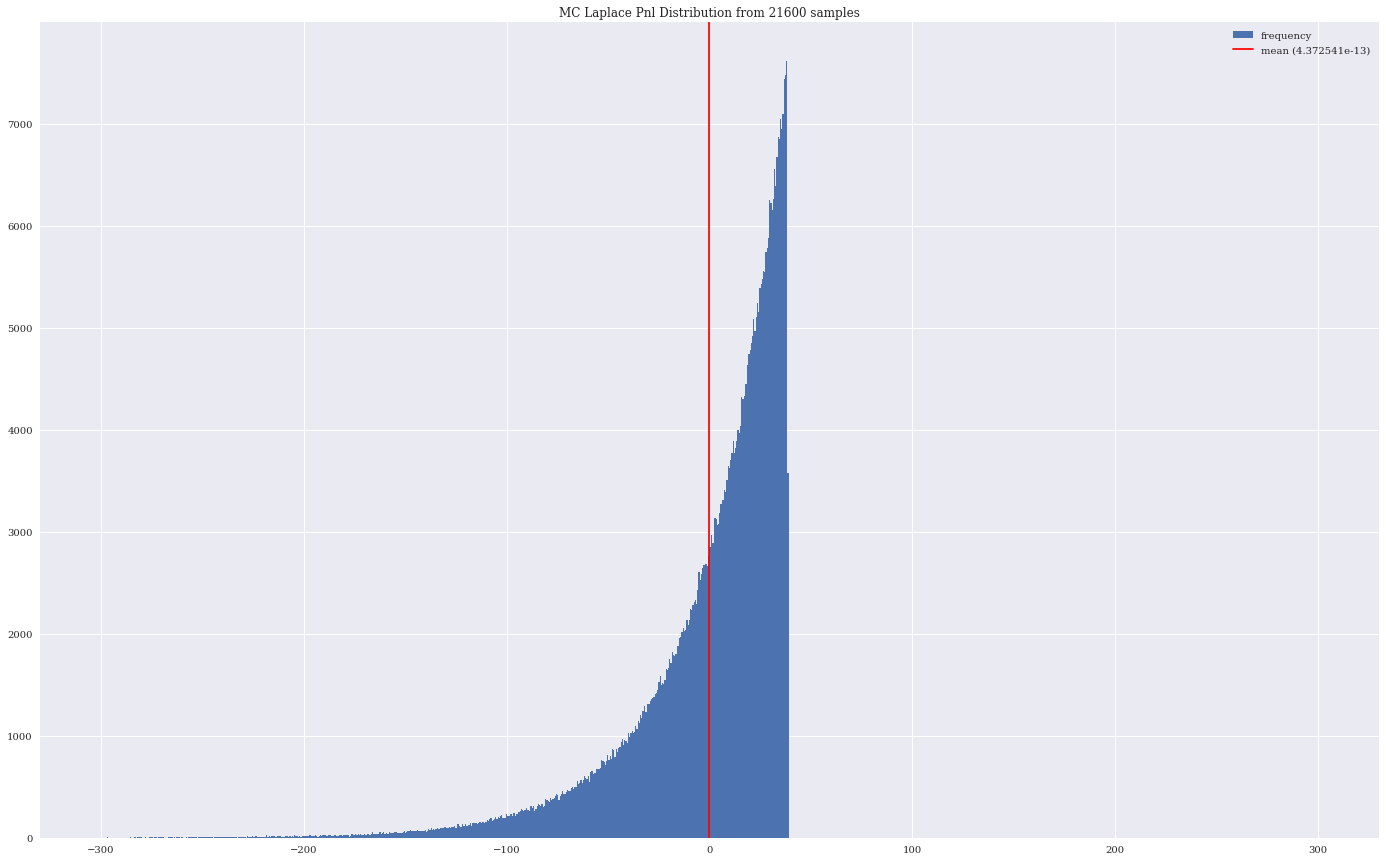

In [23]:

# calc the exercised prices
ST_exercised = ST[ST > S0]

# calc mc student's t strike
mc_laplace_strike = K_laplace_no_premium
# calc mc student's t option payoffs
mc_laplace_ct = ST_exercised - mc_laplace_strike
# calc mc student's t pnl
mc_laplace_pnl = -mc_laplace_ct


plt.figure(figsize=(24, 15))
plt.hist(mc_laplace_pnl, bins=1000, label='frequency', range=[-S0*.01, S0*0.01]);

plt.axvline(mc_laplace_pnl.mean(), color='r', label=f"mean ({float('%.7g' % (mc_laplace_pnl.mean()))})")

plt.title(f'MC Laplace Pnl Distribution from {N} samples')
plt.legend(loc='best');
plt.show()